<a href="https://colab.research.google.com/github/mike3071/Weather_Big_Data_Contest/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

load data



In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data= pd.read_csv('/content/drive/MyDrive/weather_ML/sale_weather_data_simple.csv',encoding='cp949',index_col=0,parse_dates=['날짜'],infer_datetime_format=True)

## 1) **판매량** 예측

In [ ]:
orange = data[data['소분류_감귤/한라봉/오렌지']==1].loc[:,['일별 판매 합계량(개)','평균기온(°C)','최저기온(°C)','최고기온(°C)','최소 상대습도(%)','평균 상대습도(%)','O3','PM10','일별 물품 선호도 점수']]

In [ ]:
orange

,일별 판매 합계량(개),평균기온(°C),최저기온(°C),최고기온(°C),최소 상대습도(%),평균 상대습도(%),O3,PM10,일별 물품 선호도 점수
날짜,,,,,,,,,
2018-01-01,885.0,0.066157,-3.463993,4.734708,20.763179,41.267581,0.015544,44.032069,0.000230
2018-01-02,1021.0,-0.000201,-3.617037,4.293367,25.960511,47.229263,0.013179,53.742579,0.000265
2018-01-03,1009.0,-2.328937,-4.948951,1.733667,27.184564,39.916465,0.017566,34.601134,0.000273
2018-01-04,880.0,-2.419582,-6.149132,1.320985,31.627278,44.077518,0.011983,42.672343,0.000217
2018-01-05,1080.0,-0.734189,-3.487800,3.788739,30.797391,50.195533,0.011894,51.988526,0.000297
...,...,...,...,...,...,...,...,...,...
2019-12-27,1308.0,0.153622,-2.747884,4.400667,26.304864,46.790601,0.021372,30.705457,0.000365
2019-12-28,1543.0,1.883491,-2.744505,7.183545,32.721287,48.016264,0.009785,41.573877,0.000446
2019-12-29,1425.0,3.887676,0.500345,6.753816,40.102005,62.009133,0.007811,45.826732,0.000414


In [ ]:
orange.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 700 entries, 2018-01-01 to 2019-12-31
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   일별 판매 합계량(개)  700 non-null    float64
 1   평균기온(°C)      700 non-null    float64
 2   최저기온(°C)      700 non-null    float64
 3   최고기온(°C)      700 non-null    float64
 4   최소 상대습도(%)    700 non-null    float64
 5   평균 상대습도(%)    700 non-null    float64
 6   O3            700 non-null    float64
 7   PM10          700 non-null    float64
 8   일별 물품 선호도 점수  700 non-null    float64
dtypes: float64(9)
memory usage: 54.7 KB


In [ ]:
orange.columns

Index(['일별 판매 합계량(개)', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최소 상대습도(%)',
       '평균 상대습도(%)', 'O3', 'PM10', '일별 물품 선호도 점수'],
      dtype='object')

In [ ]:
orange.isnull().sum()

일별 판매 합계량(개)    0
평균기온(°C)        0
최저기온(°C)        0
최고기온(°C)        0
최소 상대습도(%)      0
평균 상대습도(%)      0
O3              0
PM10            0
일별 물품 선호도 점수    0
dtype: int64

In [ ]:
import matplotlib.pyplot as plt

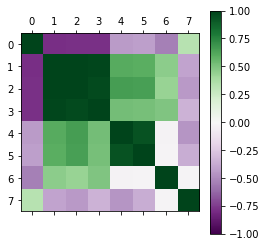

In [ ]:
plt.matshow(orange.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.colorbar()

현재 일별 판매량 예측 (전 일별 판매량과 다른 피처들을 가지고)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values = orange.values

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [ ]:
reframed = series_to_supervised(scaled,1,1)

In [ ]:
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]],axis=1, inplace=True)

In [ ]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var8(t-1)  var9(t-1)   var1(t)
1   0.199617   0.270008   0.270049  ...   0.250376   0.179099  0.232169
2   0.232169   0.268499   0.266542  ...   0.317046   0.208269  0.229296
3   0.229296   0.215551   0.236021  ...   0.185626   0.214503  0.198420
4   0.198420   0.213490   0.208518  ...   0.241041   0.168286  0.246290
5   0.246290   0.251811   0.269503  ...   0.305003   0.234342  0.146003

[5 rows x 10 columns]


splitting train, test, val set  
train: test = 7: 3

In [ ]:
values = reframed.values

In [ ]:
n_train_time = 490
train = values[:n_train_time,:]
test = values[n_train_time:,:]

In [ ]:
train_X, train_y = train[:, :-1], train[:,-1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(490, 1, 9) (490,) (209, 1, 9) (209,)


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs = 20, batch_size=70, validation_data=(test_X,test_y),verbose=2,shuffle=False)

Epoch 1/20
7/7 - 18s - loss: 0.0441 - val_loss: 0.0269
Epoch 2/20
7/7 - 0s - loss: 0.0282 - val_loss: 0.0203
Epoch 3/20
7/7 - 0s - loss: 0.0252 - val_loss: 0.0194
Epoch 4/20
7/7 - 0s - loss: 0.0243 - val_loss: 0.0173
Epoch 5/20
7/7 - 0s - loss: 0.0217 - val_loss: 0.0151
Epoch 6/20
7/7 - 0s - loss: 0.0192 - val_loss: 0.0136
Epoch 7/20
7/7 - 0s - loss: 0.0168 - val_loss: 0.0124
Epoch 8/20
7/7 - 0s - loss: 0.0152 - val_loss: 0.0111
Epoch 9/20
7/7 - 0s - loss: 0.0134 - val_loss: 0.0098
Epoch 10/20
7/7 - 0s - loss: 0.0119 - val_loss: 0.0087
Epoch 11/20
7/7 - 0s - loss: 0.0105 - val_loss: 0.0078
Epoch 12/20
7/7 - 0s - loss: 0.0090 - val_loss: 0.0070
Epoch 13/20
7/7 - 0s - loss: 0.0082 - val_loss: 0.0065
Epoch 14/20
7/7 - 0s - loss: 0.0074 - val_loss: 0.0061
Epoch 15/20
7/7 - 0s - loss: 0.0067 - val_loss: 0.0058
Epoch 16/20
7/7 - 0s - loss: 0.0064 - val_loss: 0.0054
Epoch 17/20
7/7 - 0s - loss: 0.0063 - val_loss: 0.0052
Epoch 18/20
7/7 - 0s - loss: 0.0058 - val_loss: 0.0051
Epoch 19/20
7/7 - 

In [ ]:
yhat= model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],9))
inv_yhat = np.concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 295.500


In [ ]:
orange = data[data['소분류_감귤/한라봉/오렌지']==1].loc[:,['일별 물품 선호도 점수','일별 판매 합계량(개)','평균기온(°C)','최저기온(°C)','최고기온(°C)','최소 상대습도(%)','평균 상대습도(%)','O3','PM10']]

In [ ]:
values = orange.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]],axis=1, inplace=True)
values = reframed.values
n_train_time = 490
train = values[:n_train_time,:]
test = values[n_train_time:,:]
train_X, train_y = train[:, :-1], train[:,-1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs = 20, batch_size=70, validation_data=(test_X,test_y),verbose=2,shuffle=False)
yhat= model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],9))
inv_yhat = np.concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(490, 1, 9) (490,) (209, 1, 9) (209,)
Epoch 1/20
7/7 - 2s - loss: 0.0334 - val_loss: 0.0224
Epoch 2/20
7/7 - 0s - loss: 0.0270 - val_loss: 0.0195
Epoch 3/20
7/7 - 0s - loss: 0.0246 - val_loss: 0.0179
Epoch 4/20
7/7 - 0s - loss: 0.0228 - val_loss: 0.0160
Epoch 5/20
7/7 - 0s - loss: 0.0200 - val_loss: 0.0142
Epoch 6/20
7/7 - 0s - loss: 0.0180 - val_loss: 0.0127
Epoch 7/20
7/7 - 0s - loss: 0.0158 - val_loss: 0.0114
Epoch 8/20
7/7 - 0s - loss: 0.0142 - val_loss: 0.0102
Epoch 9/20
7/7 - 0s - loss: 0.0125 - val_loss: 0.0090
Epoch 10/20
7/7 - 0s - loss: 0.0110 - val_loss: 0.0080
Epoch 11/20
7/7 - 0s - loss: 0.0099 - val_loss: 0.0071
Epoch 12/20
7/7 - 0s - loss: 0.0088 - val_loss: 0.0064
Epoch 13/20
7/7 - 0s - loss: 0.0078 - val_loss: 0.0058
Epoch 14/20
7/7 - 0s - loss: 0.0074 - val_loss: 0.0054
Epoch 15/20
7/7 - 0s - loss: 0.0067 - val_loss: 0.0051
Epoch 16/20
7/7 - 0s - loss: 0.0066 - val_loss: 0.0048
Epoch 17/20
7/7 - 0s - loss: 0.0059 - val_loss: 0.0046
Epoch 18/20
7/7 - 0s - loss: 0.0061 